In [1]:
!pip install -q torch torchtext spacy opt_einsum
!pip install -qU git+https://github.com/harvardnlp/namedtensor
!python -m spacy download en
!python -m spacy download de


    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')


    Linking successful
    /usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/de

    You can now load the model via spacy.load('de')



In [0]:
import torch
import torchtext
from torchtext.vocab import Vectors, GloVe

from namedtensor import ntorch, NamedTensor
from namedtensor.text import NamedField

import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

import matplotlib.pyplot as plt

In [0]:
def save_checkpoint(mod_enc, mod_dec, filename='checkpoint.pth.tar'):
    state_dict = {'model_encoder' : mod_enc.state_dict(),
                  'model_decoder' : mod_dec.state_dict()}
    torch.save(state_dict, filename)
    
def load_checkpoint(filename='checkpoint.pth.tar'):
    state_dict = torch.load(filename)
    return state_dict['model_encoder'], state_dict['model_decoder']
  
def set_parameters(model, sv_model, cuda=True):
    for i,p in enumerate(model.parameters()):
        p.data = sv_model[list(sv_model)[i]]
    model.cuda()

In [0]:
import torchtext
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import itertools as it

import matplotlib.pyplot as plt
import spacy
import time

MAX_LEN = 20
MIN_FREQ = 5

In [0]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

BOS_WORD = '<s>'
EOS_WORD = '</s>'
DE = data.Field(tokenize=tokenize_de)

# only target needs BOS/EOS:
EN = data.Field(tokenize=tokenize_en, init_token = BOS_WORD, eos_token = EOS_WORD) 

train, val, test = datasets.IWSLT.splits(exts=('.de', '.en'), fields=(DE, EN), 
                                         filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
                                         len(vars(x)['trg']) <= MAX_LEN)

In [6]:
!curl -O https://raw.githubusercontent.com/harvard-ml-courses/cs287-s18/master/HW3/source_test.txt
!head source_test.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50587  100 50587    0     0   115k      0 --:--:-- --:--:-- --:--:--  115k
Als ich in meinen 20ern war , hatte ich meine erste Psychotherapie-Patientin .
Ich war Doktorandin und studierte Klinische Psychologie in Berkeley .
Sie war eine 26-jährige Frau namens Alex .
Und als ich das hörte , war ich erleichtert .
Meine Kommilitonin bekam nämlich einen Brandstifter als ersten Patienten .
Und ich bekam eine Frau in den 20ern , die über Jungs reden wollte .
Das kriege ich hin , dachte ich mir .
Aber ich habe es nicht hingekriegt .
Arbeit kam später , Heiraten kam später , Kinder kamen später , selbst der Tod kam später .
Leute in den 20ern wie Alex und ich hatten nichts als Zeit .


In [0]:
DE.build_vocab(train.src, min_freq=MIN_FREQ)
EN.build_vocab(train.trg, min_freq=MIN_FREQ)

pred_set = []
for i, line in enumerate(open("source_test.txt"), 1):
    words = line.split()# [:-1]
    pred_set.append([DE.vocab.stoi[s] for s in words])

device = torch.device('cuda')
train_iter, val_iter, test_iter = data.BucketIterator.splits((train, val, test), batch_size=32, device=device,
                                                  repeat=False, sort_key=lambda x: len(x.src))

In [0]:
batch = next(iter(test_iter))
# sent_inspect(batch,4)
def sent_inspect(batch, idx=0):
    print("Source")
    print(' '.join([DE.vocab.itos[w] for w in batch.src.data[:,idx]]))
    print("Target")
    print(' '.join([EN.vocab.itos[w] for w in batch.trg.data[:,idx]]))
# print(DE.vocab.stoi['<pad>'])

## Models

In [0]:
class EmbeddingLM(nn.Module):
    def __init__(self, TEXT, dropout=0.0, max_embedding_norm=None, embedding_size=1000):
        super(EmbeddingLM, self).__init__()
        self.dropout_prob = dropout
        self.dropout = nn.Dropout(self.dropout_prob)
        
        self.vocab_size = len(TEXT.vocab)
        self.embedding_dim = embedding_size
        self.embeddings = nn.Embedding(self.vocab_size, self.embedding_dim, 
                                       max_norm=max_embedding_norm)

class EncoderLSTM(EmbeddingLM):
    def __init__(self, TEXT, hidden_size=500, num_layers=2,
                 bidirectional=False, **kwargs):
        super(EncoderLSTM, self).__init__(TEXT, **kwargs)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.hidden_size,
                            num_layers=self.num_layers,
                            dropout=self.dropout_prob, batch_first=True,
                            bidirectional=self.bidirectional)

        
    def forward(self, input, hidden):
        x = self.embeddings(input)  # batch size, sentence len, embedding dim
        x = self.dropout(x)
        output, hidden = self.lstm(x, hidden)
        return output, hidden  # batch, sentence len, hidden size * 1 or 2


class DecoderLSTM(EncoderLSTM):
    """Inherit same architecture as encoder, but reversed"""
    def __init__(self, TEXT, context_size=1, bidirectional_encoder=False, **kwargs):
        super(DecoderLSTM, self).__init__(TEXT, **kwargs)
        self.context_size = context_size
        self.encoder_dirs = 2 if bidirectional_encoder else 1
        input_dim = self.context_size * self.num_layers * self.encoder_dirs + 1
        self.output = nn.Linear(input_dim * self.hidden_size, self.vocab_size)

    def forward(self, input, hidden, context):
        """:context: tuple (h, c) of hidden and cell states from t-1 of encoder"""
        x = self.embeddings(input)
        x = F.relu(x)
        output, hidden = self.lstm(x, hidden)

        if self.context_size:
            context_var = torch.cat(context[:self.context_size])
            batch_size = context_var.size(1)
            sentence_len = output.size(1)

            # Convert this to named version? rn [batch_size, 1, hidden_size * context_size]
            context_var = context_var.permute(1, 0, 2).contiguous().view(batch_size, 1, -1)
            context_var = context_var.expand(-1, sentence_len, -1)
            output = torch.cat((output, context_var), dim=2)

        output = self.output(output)
        output = F.log_softmax(output, dim=2)
        return output, hidden


class DecoderAttn(EncoderLSTM):
    def __init__(self, TEXT, bidirectional_encoder=False, tie_weights=False,
                 linear_encoder=0, **kwargs):
        super(DecoderAttn, self).__init__(TEXT, **kwargs)
        print('Using final MLP')
        self.encoder_dirs = 2 if bidirectional_encoder else 1

        dims = self.encoder_dirs  
        self.output_decoder = nn.Linear(self.hidden_size, self.vocab_size)
        self.output_context = nn.Linear(dims * self.hidden_size, self.vocab_size)

        self.linear_encoder = linear_encoder
        if self.linear_encoder > 0:
            self.attn_linear = nn.Linear(self.encoder_dirs * self.linear_encoder,
                                         self.hidden_size)

        if tie_weights:
            if self.hidden_size != self.embedding_dim:
                raise ValueError('Tied weights require hidden size to equal embedding dimension!')
            self.output_decoder.weight = self.embeddings.weight
        
    def forward(self, input, hidden, encoded_output, mask_ix=None):
        embedding = self.embeddings(input)
        embedding = self.dropout(embedding)
        decoder_output, hidden = self.lstm(embedding, hidden)
        
        # Attention
        if self.linear_encoder > 0:
            output_linear_encoder = self.attn_linear(encoded_output)
        else:
            output_linear_encoder = encoded_output

        # output_encoder_prm is [batch_size, hidden_size, sentence_len (src)] <- TODO: Named
        output_encoder_perm = output_linear_encoder.permute(0, 2, 1)
        products = torch.bmm(decoder_output, output_encoder_perm)

        # mask_ix is [batch_size, sentence_len_src]
        if mask_ix is not None:
            mask_ix = Variable(torch.Tensor([np.inf])) * mask_ix
            mask_ix[mask_ix != mask_ix] = 0
            products = products - torch.unsqueeze(mask_ix, 1)
        
        product_softmax = F.softmax(products, dim=2)
        context = torch.bmm(product_softmax, encoded_output)

        output_1 = self.output_decoder(self.dropout(decoder_output))
        output_2 = self.output_context(self.dropout(context))
        
        output = output_1 + output_2
        output = F.log_softmax(output, dim=2)
        
        return output, hidden, product_softmax 

## Training Stuff

In [0]:
class TrainTestBase(object):
    """
    Parent class for training and evaluation
    :models: should be list of [encoder, decoder]
    """
    def __init__(self, models, TEXT_SRC, TEXT_TRG, mask_src=False,
                 attention=False, reverse_encoder_input=False, cuda=True):
        self.TEXT_SRC = TEXT_SRC
        self.TEXT_TRG = TEXT_TRG
        self.padding_src = TEXT_SRC.vocab.stoi['<pad>']
        self.padding_trg = TEXT_TRG.vocab.stoi['<pad>']

        self.models = models
        self.mask_src = mask_src
        self.use_attention = attention
        self.record_attention = False
        self.reverse_encoder_input = reverse_encoder_input
        self.cuda = cuda and torch.cuda.is_available()
        if self.cuda:
            print('Using CUDA')

    def get_src_and_trg(self, batch):
        if self.reverse_encoder_input:
            src_data = torch.t(batch.src.data)
            ix_rev = torch.LongTensor(np.arange(src_data.size(1) - 1, -1, -1))
            src = torch.index_select(torch.t(batch.src.data), dim=1,
                                     index=ix_rev)
            src = src.contiguous()
        else:
            src = torch.t(batch.src.data).contiguous()
        trg = torch.t(batch.trg.data)
        trg_feature = trg[:, :-1].contiguous()
        trg_label = trg[:, 1:].contiguous()
        return (src, trg_feature, trg_label)

    def initial_hidden(self, batch_size, model_ix):
        num_directions = 2 if self.models[model_ix].bidirectional else 1
        return torch.zeros(self.models[model_ix].num_layers * num_directions, 
                           batch_size, self.models[model_ix].hidden_size)

    def init_hidden(self, batch_size, zeros=True, model_ix=0):
        if (self.prev_hidden is not None) and (not zeros):
            hidden = self.prev_hidden
        else:
            hidden = (self.initial_hidden(batch_size, model_ix) for i in range(2))
        if self.cuda:
            hidden = tuple(h.cuda() for h in hidden)
        return tuple(Variable(h) for h in hidden)

    def init_model_inputs(self, batch, **kwargs):
        if self.cuda:
            src, trg_feature, trg_label = tuple(x.cuda() for x in self.get_src_and_trg(batch))
        else:
            src, trg_feature, trg_label = self.get_src_and_trg(batch)

        assert batch.src.size(1) == batch.trg.size(1)
        hidden = self.init_hidden(batch.src.size(1), **kwargs)
        return (Variable(src), Variable(trg_feature), Variable(trg_label), hidden)

    def init_epoch(self):
        self.prev_hidden = None

    def set_prev_hidden(self, hidden):
        if self.models[1].encoder_dirs == 2:
            self.prev_hidden = tuple(h[self.models[0].num_layers:, :, :] for h in hidden)
        else:
            self.prev_hidden = hidden

    def get_attn_marsk(self, src):
        if self.mask_src:
            mask_padding = torch.eq(src, self.padding_src).type(torch.FloatTensor)
            mask_padding = mask_padding.cuda() if self.cuda else mask_padding
            return mask_padding
        else:
            return None
        
    def run_model(self, batch, mode='mean'):
        src, trg_feature, trg_label, hidden = self.init_model_inputs(batch, zeros=True, model_ix=0)

        encoded_output, encoded_hidden = self.models[0](src, hidden)
        self.set_prev_hidden(encoded_hidden)
            
        if self.use_attention:
            mask_padding = self.get_attn_marsk(src)
            decoder_output, decoder_hidden, decoder_attn = self.models[1](
                trg_feature, self.prev_hidden, encoded_output, mask_padding)
            if self.record_attention:
                _, pred = torch.topk(decoder_output, k=1, dim=2)
                self.attn_log.append((decoder_attn, src, pred.squeeze(), trg_label))
        else:
            decoder_output, decoder_hidden = self.models[1](
                trg_feature, self.prev_hidden, encoded_hidden)
            
        self.prev_hidden = decoder_hidden
        return self.nll_loss(decoder_output, trg_label, mode=mode)

    def nll_loss(self, log_probs, output, mode='mean', **kwargs):
        batch_size = log_probs.size(0)
        typing = torch.cuda.FloatTensor if self.cuda else torch.FloatTensor
        sentence_len = torch.sum((output != self.padding_trg).type(typing)) / batch_size

        log_probs_ = log_probs.view(-1, log_probs.size(2))
        output_ = output.view(-1)
        if mode == 'mean':
            return F.nll_loss(log_probs_, output_, ignore_index=self.padding_trg, **kwargs) * sentence_len
        elif mode == 'sum':
            return F.nll_loss(log_probs_, output_, ignore_index=self.padding_trg, size_average=False)

            
class ModelEval(TrainTestBase):
    def __init__(self, models, TEXT_SRC, TEXT_TRG, record_attention=False,
                 visualize_freq=None, **kwargs):
        """
        Validation class. Requires matplotlib for the visualization
        """
        super(ModelEval, self).__init__(models, TEXT_SRC, TEXT_TRG,
                                           **kwargs)
        self.record_attention = record_attention
        self.visualize_freq = visualize_freq
        
    def init_epoch(self):
        super(ModelEval, self).init_epoch()
        self.attn_log = list()
        
    def visualize_attn(self, decoder_attn_sample, src_sample, pred_sample,
                       trg_label=None, save_name=None):
        attn = decoder_attn_sample.cpu().data.numpy()
        src_words = np.array(list(map(lambda x: self.TEXT_SRC.vocab.itos[x], 
                                      src_sample.cpu().data.numpy())))
        pred_words = np.array(list(map(lambda x: self.TEXT_TRG.vocab.itos[x], 
                                       pred_sample.cpu().data.numpy())))
        if not trg_label is None:
            trg_cpu = trg_label.cpu().data.numpy()
            trg_words = np.array(list(map(lambda x : self.TEXT_TRG.vocab.itos[x],
                                         trg_cpu)))
            pred_words = np.array(['%s (%s)' % (pred_words[i], trg_words[i]) for \
                                   i in range(pred_words.shape[0])])
            pad_ix = np.where(trg_words == '<pad>')[0]
            if len(pad_ix):
                clip_len = pad_ix[0]
                trg_words = trg_words[:clip_len]
                pred_words = pred_words[:clip_len]
                attn = attn[:clip_len, :]
        
        # Visualizations
        fig, ax = plt.subplots()
        ax.imshow(attn, cmap='gray')
        plt.xticks(range(len(src_words)), src_words, rotation='vertical')
        plt.yticks(range(len(pred_words)), pred_words)

        ax.xaxis.tick_top()

        if not save_name is None:
            plt.savefig(save_name)
        plt.show()

    def evaluate(self, test_iter, num_iter=None):
        start_time = time.time()
        for model in self.models:
            model.eval()

        nll_sum = 0
        nll_count = 0

        self.init_epoch()
        test_iter.init_epoch()

        for i, batch in enumerate(test_iter):
            nll_count += batch.trg.data.numel()
            loss = self.run_model(batch, mode='sum')
            nll_sum += loss.data.item()
            
            if self.visualize_freq and i % self.visualize_freq == 0:
                sample = self.attn_log[-1]
                self.visualize_attn(sample[0][0], sample[1][0], sample[2][0])
            if not num_iter is None and i > num_iter:
                break
                        
        for model in self.models:
            model.train()
        
        print('Validation time: %f seconds' % (time.time() - start_time))
        return np.exp(nll_sum / nll_count)
    
    # Performs beam search
    def beam_search_predict(self, sentence, ref_beam, ref_vocab, 
                            beam_size=100, pred_len=3, pred_num=None,
                            ignore_eos=False, translate=False):
        """Beam search implementation for selecting viable translations"""
        if pred_num is None:
            pred_num = beam_size
        
        # [sentence_len]
        tensor_sentence = torch.LongTensor(sentence)
        if self.reverse_encoder_input:
            ix_rev = torch.LongTensor(np.arange(tensor_sentence.size(0) - 1, -1, -1))
            tensor_sentence = torch.index_select(tensor_sentence, dim=0,
                                          index=ix_rev)
        if self.cuda:
            tensor_sentence = tensor_sentence.cuda()   

        src = Variable(tensor_sentence.view(1, -1).expand(beam_size, -1))
        hidden = self.init_hidden(beam_size, zeros=True)
        
        # For attention, will use encoder_output (not otherwise)
        encoder_output, encoder_hidden = self.models[0](src, hidden)
        self.set_prev_hidden(encoder_hidden)
        
        sos_token = self.TEXT_TRG.vocab.stoi['<s>']  # Start with SOS  
        self.current_beams = (sos_token * torch.ones(beam_size, 1)).type(torch.LongTensor)
        self.current_beam_vals = torch.zeros(beam_size, 1).type(torch.FloatTensor)
        if self.cuda:
            self.current_beams = self.current_beams.cuda()
            self.current_beam_vals = self.current_beam_vals.cuda()
        self.current_beams = Variable(self.current_beams)
        self.current_beam_vals = Variable(self.current_beam_vals)

        if translate:
            final_preds = list()

        for i in range(pred_len):
            if translate:
                (ref_beam, ref_vocab) = self.create_ref_arrays(self.current_beams.size(0))

            current_sentence = self.current_beams[:, i:i+1]
            if self.use_attention:
                mask_padding = self.get_attn_marsk(src)

                decoder_output, decoder_hidden, decoder_attn = self.models[1](
                    current_sentence, self.prev_hidden, encoder_output[:self.current_beams.size(0)], mask_padding)
                if self.record_attention:
                    _, pred = torch.topk(decoder_output, k=1, dim=2)
                    self.attn_log.append((decoder_attn, src, pred.squeeze(), None))
            else:
                decoder_output, decoder_hidden = self.models[1](
                    current_sentence, self.prev_hidden, encoder_hidden)
            self.prev_hidden = decoder_hidden
            
            decoder_output = decoder_output.squeeze()

            if ignore_eos:  # EOS tokens  
                eos_token = self.TEXT_TRG.vocab.stoi['</s>']
                decoder_output[:, eos_token] = -np.inf

            decoder_output = decoder_output + self.current_beam_vals

            if i == 0:
                decoder_output = decoder_output[0, :]
            else:
                decoder_output = decoder_output.view(-1)
                
            topk_dec, topk_ix = torch.topk(decoder_output, k=beam_size)
            prev_ix = torch.index_select(ref_beam, dim=0, index=topk_ix)
            prevs = torch.index_select(self.current_beams, dim=0, index=prev_ix)

            # Update hidden to reflect previous sentences picked
            self.prev_hidden = tuple(torch.index_select(
                    self.prev_hidden[j], dim=1, index=prev_ix) for j in range(len(self.prev_hidden)))
            
            # Update current baem values  
            self.current_beam_vals = topk_dec.view(-1, 1)
            nexts = torch.index_select(ref_vocab, dim=0, index=topk_ix).view(-1, 1)
            self.current_beams = torch.cat((prevs, nexts), dim=1)

            if translate:
                sentences_ = list()
                eos_token = self.TEXT_TRG.vocab.stoi['</s>']
                for i in range(self.current_beams.size(0)):
                    if self.current_beams[i,-1].data.item() == eos_token:
                        final_preds.append(self.current_beams[i,:])
                    else:
                        sentences_.append(i)
                keep_ix = Variable(torch.LongTensor(sentences_))
                keep_ix = keep_ix.cuda() if self.cuda else keep_ix

                # Now reselect
                if len(sentences_) > 100 or len(keep_ix) == 0:
                    return final_preds           
                self.current_beams = torch.index_select(self.current_beams, 0, keep_ix)
                self.current_beam_vals = torch.index_select(self.current_beam_vals, 0, keep_ix)
                self.prev_hidden = tuple(torch.index_select(self.prev_hidden[j], 1, keep_ix) 
                                         for j in range(len(self.prev_hidden)))

        if translate:
            return final_preds
        return self.current_beams
    
    def escape(self, l):
        return l.replace("\"", "<quote>").replace(",", "<comma>")

    def create_ref_arrays(self, beam_size):
        # Keep track of ix for expanding beams and vocab
        trg_vocab_size = len(self.TEXT_TRG.vocab)
        ref_beam = torch.LongTensor(np.arange(beam_size)).view(-1, 1).expand(-1, trg_vocab_size)
        ref_beam = ref_beam.contiguous().view(-1)
        ref_beam = ref_beam.cuda() if self.cuda else ref_beam
        ref_beam = Variable(ref_beam)
        
        ref_vocab = torch.LongTensor(np.arange(trg_vocab_size)).view(1, -1).expand(beam_size, -1)
        ref_vocab = ref_vocab.contiguous().view(-1)
        ref_vocab = ref_vocab.cuda() if self.cuda else ref_vocab
        ref_vocab = Variable(ref_vocab)
        return (ref_beam, ref_vocab)
    
    def create_text(self, word_ids, src, is_variable=False):
        """:src: True or False specifying what language"""
        TEXT = self.TEXT_SRC if src else self.TEXT_TRG
        if is_variable:
            words = [TEXT.vocab.itos[word_ids[k].data.item()] for k in range(1, len(word_ids))]
        else:
            words = [TEXT.vocab.itos[word_ids[k]] for k in range(1, len(word_ids))]
        return ' '.join(words)
        
    
    def view_predictions(self, batch_src, batch_trg, batch_preds):
        for i,sent in enumerate(batch_src):
            if i > 10:
                break
            words_src = self.create_text(sent, True)
            words_trg = self.create_text(batch_trg[i], False)
            words_pred_list = []
            for j in range(len(batch_preds[i])):
                words_pred_list.append(self.create_text(batch_preds[i][j], False,
                                                       is_variable=True))
            for w in words_pred_list:
                print(w)
            
        
    def predict(self, test_set, fname='predictions.txt', num_cands=100, pred_len=3,
                beam_size=100, ignore_eos=False, translate=False):
        start_time = time.time()
        for model in self.models:
            model.eval()

        (ref_beam, ref_vocab) = self.create_ref_arrays(beam_size)
            
        self.init_epoch()
        predictions = []
        for i, sentence in enumerate(test_set):
            # [pred_num, pred_len] tensor
            translations = self.beam_search_predict(sentence, ref_beam=ref_beam, 
                                                    ref_vocab=ref_vocab, pred_len=pred_len,
                                                    beam_size=beam_size, ignore_eos=ignore_eos,
                                                    translate=translate)
            predictions.append(translations)            
        if translate:
            return predictions
            
        print('Writing predictions to %s' % fname)
        with open(fname, 'w') as fout:
            print('id,Predicted', file=fout)
            for i, preds in enumerate(predictions):
                candidates = []
                for j in range(num_cands):
                    words = [self.TEXT_TRG.vocab.itos[preds[j,k].data.item()] for k in range(1, pred_len + 1)]
                    sent = '|'.join(self.escape(l) for l in words)
                    candidates.append(sent)
                print('%d,%s' % (i, ' '.join(candidates)), file=fout)
        print('Computing predictions took %f seconds' % (time.time() - start_time))
        
        # Wrap model.eavl
        for model in self.models:
            model.train()
            

    
class ModelTrain(TrainTestBase):
    def __init__(self, models, TEXT_SRC, TEXT_TRG, lr=0.1, optimizer=optim.SGD, 
                 lrn_decay=None, lrn_decay_force=np.inf, lrn_decay_rate=0.1,
                 clip_norm=10, **kwargs):
        '''
        Class to train models.  
        :lr_decay_type: type of learning rate decay, pick 'adaptive' or 'linear'
        '''
        super(NMTTrainer, self).__init__(models, TEXT_SRC, TEXT_TRG, **kwargs)

        self.base_lr = lr
        self.optimizer_type = optimizer
        self.init_optimizers()  # Optimizer for each model

        # Learning rate decay
        self.lr_decay_type = lrn_decay
        self.lr_decay_force = lrn_decay_force

        if self.lr_decay_type is None or self.lr_decay_type == 'adaptive':
            self.lr_lambda = lambda i : 1
        elif self.lr_decay_type == 'linear':
            decay_rate = lrn_decay_rate
            self.lr_lambda = lambda i : 1 / (1 + (i - 6) * decay_rate) if i > 6 else 1
        
        self.schedulers = [optim.lr_scheduler.LambdaLR(optimizer,
            self.lr_lambda) for optimizer in self.optimizers]

        self.clip_norm = clip_norm
        self.restart_logs()
        if self.cuda:
            for model in self.models:
                model.cuda()
                
    def init_optimizers(self):
        self.optimizers = [self.optimizer_type(filter(lambda p : p.requires_grad,
                                                      model.parameters()),
                                               lr = self.base_lr) for \
                           model in self.models]

    def restart_logs(self):
        self.training_losses = list()
        self.training_norms = list()
        self.val_performance = list()

    def get_loss_data(self, loss):
        if self.cuda:
            return loss.data.cpu().numpy()
        else:
            return loss.data.numpy()[0]

    def record_updates(self, loss, norm):
        self.training_norms.append(norm)
        self.training_losses.append(loss)

    def clip_norms(self):
        if self.clip_norm > 0:
            parameters = tuple()
            for model in self.models:
                parameters += tuple(model.parameters())
                
            norm = nn.utils.clip_grad_norm(parameters, self.clip_norm)
        else:
            norm = -1
        return norm

    def train_batch(self, batch, **kwargs):
        for model in self.models:
            model.zero_grad()
        loss = self.run_model(batch)
        loss.backward()

        norm = self.clip_norms()

        loss_data = self.get_loss_data(loss)

        if kwargs.get('verbose', False):
            self.record_updates(loss_data, norm)

        for optimizer in self.optimizers:
            optimizer.step()

        return loss_data, norm

    def init_parameters(self):
        for model in self.models:
            for p in model.parameters():
                p.data.uniform_(-0.05, 0.05)

    def train(self, train_iter, eval_=None, val_iter=None,
              save_model_fname=None, init_parameters=True, **kwargs):
        self.restart_logs()
        start_time = time.time()
        print("Initializing parameters status: ", init_parameters)
        if init_parameters:
            self.init_parameters()

        train_iter.init_epoch()

        for epoch in range(kwargs.get('num_iter', 100)):
            self.init_epoch()
            for model in self.models:
                model.train()
                
            # Learning rate decay?
            if self.lr_decay_type == 'adaptive':
                if (epoch > 2 and self.val_performance[-1] > self.val_performance[-2]) or (epoch >= self.lr_decay_force):
                    self.base_lr = self.base_lr / 2
                    self.init_optimizers()  
                    print('Decay LR to %f' % self.base_lr)
            else:
                for scheduler in self.schedulers:
                    scheduler.step()

            train_iter = iter(train_iter)

            for batch in train_iter:
                result_loss, result_norm = self.train_batch(batch, **kwargs)

            if epoch % kwargs.get('skip_iter', 1) == 0:
                if not kwargs.get('verbose', False):
                    self.record_updates(result_loss, result_norm)

            print('Epoch %d, loss: %f, norm: %f, elapsed: %f, lr: %f' \
                  % (epoch, np.mean(self.training_losses[-10:]),
                     np.mean(self.training_norms[-10:]),
                     time.time() - start_time, self.base_lr)) 
                    
            if (eval_ is not None) and (val_iter is not None):
                self.val_performance.append(eval_.evaluate(val_iter))
                print('Validation set metric: %f' % \
                      self.val_performance[-1])

            if save_model_fname is not None:
                path_name = save_model_fname + '.epoch_%d.ckpt.tar' % epoch
                print('Saving model')
                save_checkpoint(self.models[0], self.models[1], path_name)

        if len(self.val_performance) >= 1:  # Check for final submission, but probably will stop before this
            print('FINAL VAL PERF', self.val_performance[-1])
            return self.val_performance[-1]
        return -1

### Call these to train new model  
Better to load saved model below

In [0]:
# device = torch.device('cuda')
# train_iter, val_iter = data.BucketIterator.splits((train, val), batch_size=32, device=device,
#                                                   repeat=False, sort_key=lambda x: len(x.src))
# bs_encoder = Encod`erLSTM(DE, hidden_size=500, num_layers=4, embedding_size=500)
# at_decoder = DecoderAttn(EN, hidden_size=500, num_layers=4, embedding_size=500)
# trainer = ModelTrain([bs_encoder, bs_decoder], DE, EN, lr=0.7, 
#                      lr_decay_type='adaptive', reverse_encoder_input=False)
# evaluator = ModelEval([bs_encoder, bs_decoder], DE, EN, reverse_encoder_input=False)
# trainer.train(train_iter, val_iter=val_iter,eval_=evaluator)

train_iter, val_iter = data.BucketIterator.splits((train, val), batch_size=32, device=device,
                                                  repeat=False, sort_key=lambda x: len(x.src))
bs_encoder = EncoderLSTM(DE, hidden_size=650, num_layers=4, embedding_size=650, 
                         bidirectional=True, dropout=0.35)
at_decoder = DecoderAttn(EN, hidden_size=650, num_layers=4, embedding_size=650, 
                         dropout=0.35, tie_weights=True, linear_encoder=650, 
                         bidirectional_encoder=True)
trainer = ModelTrain([bs_encoder, at_decoder], DE, EN, lr=1.2, 
                     lr_decay_type='adaptive', attention=True,
                     clip_norm=5)
evaluator = ModelEval([bs_encoder, at_decoder], DE, EN, attention=True,
                        record_attention=False)
trainer.train(train_iter, verbose=True, eval_=evaluator, val_iter=val_iter,
              save_model_fname='attn', num_iter=20)

### Load saved model for prediction

In [13]:
ld_enc, ld_dec = load_checkpoint('attn.epoch_10.ckpt.tar')
ld_encoder = EncoderLSTM(DE, hidden_size=650, num_layers=4, embedding_size=650, 
                         bidirectional=True, dropout=0.35)
ld_decoder = DecoderAttn(EN, hidden_size=650, num_layers=4, embedding_size=650, 
                         dropout=0.35, tie_weights=False, linear_encoder=650, 
                         bidirectional_encoder=True)
set_parameters(ld_encoder, ld_enc)
set_parameters(ld_decoder, ld_dec)
evaluator = ModelEval([ld_encoder, ld_decoder], DE, EN, attention=True,
                        record_attention=False)
evaluator.predict(pred_set, fname='predictions_100.txt', beam_size=100, ignore_eos=True)

Using final MLP
Using CUDA
Writing predictions to predictions_100.txt
Computing predictions took 101.279886 seconds


### Call following for visualization

In [14]:
def load_validate_model(fn):
    ld_enc, ld_dec = load_checkpoint(fn)
    ld_encoder = EncoderLSTM(DE, hidden_size=650, num_layers=4, embedding_size=650, 
                             bidirectional=True, dropout=0.35)
    ld_decoder = DecoderAttn(EN, hidden_size=650, num_layers=4, embedding_size=650, dropout=0.35,
                             tie_weights=False, linear_encoder=650,
                             bidirectional_encoder=True)
    set_parameters(ld_encoder, ld_enc)
    set_parameters(ld_decoder, ld_dec)
    evaluator = ModelEval([ld_encoder, ld_decoder], DE, EN, attention=True,
                          record_attention=True)
    print(evaluator.evaluate(val_iter))
    return evaluator
evaluator=load_validate_model('attn.epoch_10.ckpt.tar')

Using final MLP
Using CUDA


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Validation time: 1.257690 seconds
4.483508558372544


In [0]:
def get_images(number=10):
    for x in range(number):
        attn_list = list(evaluator.attn_log[17][i][x + 1] for i in range(4))
        fname = 'attn_vis_{}.png'.format(x + 1)
        attn_list.append(fname)
        print(len(attn_list))
        evaluator.visualize_attn(*attn_list)
        plt.savefig(fname)

5


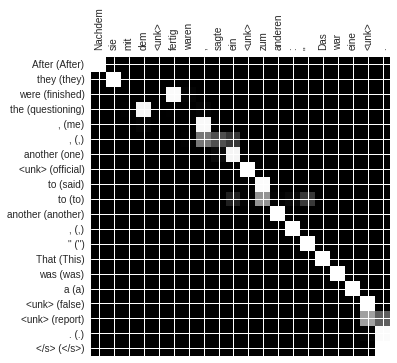

5


<Figure size 576x396 with 0 Axes>

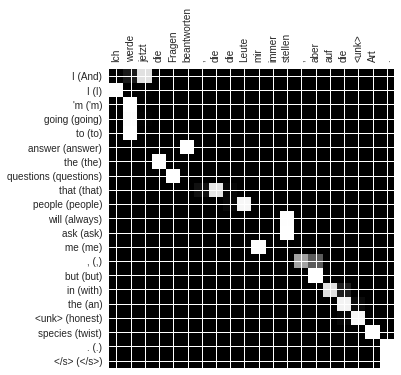

<Figure size 576x396 with 0 Axes>

In [16]:
get_images(2)

### Throws cuda out of memory?

In [0]:
translation = evaluator.predict(pred_set, fname='translation.txt', beam_size=10, ignore_eos=True, translate=True)

In [18]:
translation

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
